In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from tqdm import tqdm

ModuleNotFoundError: No module named 'skimage'

Definir nome da pasta do diretório e parametros do HOG

In [ ]:
base_path = 'clahe_'
pixels_per_cell_options = [(16, 16), (20, 20)]
sizes = ['128', '256']

Definição de função para ler as imagens e extrair as características HOG

In [ ]:
def extract_hog_features(image_folder, label, hog_params):
    features = []
    for img_name in tqdm(os.listdir(image_folder), desc=f'Extraindo de {image_folder}'):
        img_path = os.path.join(image_folder, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        fd, hog_image = hog(
            image,
            orientations=9,
            pixels_per_cell=hog_params,
            cells_per_block=(2, 2),
            visualize=True,
        )

        features.append(np.append(fd, label))
    
    return np.array(features)


Aplicação do HOG e definição das características

In [ ]:

for size in sizes:
    for ppc in pixels_per_cell_options:
        folder_no_dr = f'{base_path}{size}/no_DR'
        folder_with_dr = f'{base_path}{size}/with_DR'

        features_no_dr = extract_hog_features(folder_no_dr, label=0, hog_params=ppc)
        features_with_dr = extract_hog_features(folder_with_dr, label=1, hog_params=ppc)

        features_combined = np.vstack([features_no_dr, features_with_dr])

        output_csv = f'hog_{size}_{ppc[0]}x{ppc[1]}.csv'
        pd.DataFrame(features_combined).to_csv(output_csv, index=False)
        print(f'Salvo: {output_csv}')


Extraindo de clahe_128/with_DR: 100%|██████████| 400/400 [00:04<00:00, 86.96it/s]


Salvo: hog_128_16x16.csv


Extraindo de clahe_128/with_DR: 100%|██████████| 400/400 [00:01<00:00, 202.49it/s]


Salvo: hog_128_20x20.csv


Extraindo de clahe_256/with_DR: 100%|██████████| 400/400 [00:12<00:00, 32.67it/s]


Salvo: hog_256_16x16.csv


Extraindo de clahe_256/with_DR: 100%|██████████| 400/400 [00:07<00:00, 52.39it/s]


Salvo: hog_256_20x20.csv


Importa as bibliotecas que será usadas na extração de Features 

In [ ]:
import os
import cv2
import numpy as np
print(cv2.__version__)
print(np.__version__)
import pandas as pd
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

4.11.0
1.24.3


Definindo a função que extrai e salva os parâmetros

In [ ]:
def extract_cnn_features(model, folder_path, image_size, label_map, output_path):
    import cv2
    import numpy as np
    import pandas as pd
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras.applications.vgg16 import preprocess_input
    from tqdm import tqdm

    input_shape = (image_size, image_size)
    features = []

    for label_folder, label in label_map.items():
        full_path = os.path.join(folder_path, label_folder)

        for file in tqdm(os.listdir(full_path), desc=f'{folder_path} - {label_folder}'):
            img_path = os.path.join(full_path, file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, input_shape)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            feature = model.predict(img_array, verbose=0).flatten()
            features.append(np.append(feature, label))

    df = pd.DataFrame(features)
    df.to_csv(output_path, index=False)
    print(f'✅ Salvo: {output_path}')

Define os parametros e executa os laços

In [ ]:
sizes = [128, 256]
poolings = ['avg', 'max']
models = {'vgg16': VGG16, 'vgg19': VGG19}
label_map = {'with_DR': 1, 'no_DR': 0}

# Loop pelas combinações
for size in sizes:
    for pooling in poolings:
        for model_name, model_func in models.items():
            base_model = model_func(weights='imagenet', include_top=False, input_shape=(size, size, 3))

            if pooling == 'avg':
                output = GlobalAveragePooling2D()(base_model.output)
            else:
                output = GlobalMaxPooling2D()(base_model.output)

            model = Model(inputs=base_model.input, outputs=output)

            folder_path = f'clahe_{size}'
            output_csv = f'{model_name}_{pooling}_{size}.csv'

            extract_cnn_features(model, folder_path, size, label_map, output_csv)

58889256/58889256 [==============================] - 3s 0us/step


clahe_128 - no_DR: 100%|██████████| 400/400 [00:27<00:00, 14.45it/s]


✅ Salvo: vgg16_avg_128.csv
80134624/80134624 [==============================] - 3s 0us/step


clahe_128 - no_DR: 100%|██████████| 400/400 [00:30<00:00, 13.01it/s]


✅ Salvo: vgg19_avg_128.csv


clahe_128 - no_DR: 100%|██████████| 400/400 [00:28<00:00, 13.93it/s]


✅ Salvo: vgg16_max_128.csv


clahe_128 - no_DR: 100%|██████████| 400/400 [00:34<00:00, 11.43it/s]


✅ Salvo: vgg19_max_128.csv


clahe_256 - no_DR: 100%|██████████| 400/400 [01:16<00:00,  5.20it/s]


✅ Salvo: vgg16_avg_256.csv


clahe_256 - no_DR: 100%|██████████| 400/400 [02:01<00:00,  3.28it/s]


✅ Salvo: vgg19_avg_256.csv


clahe_256 - no_DR: 100%|██████████| 400/400 [02:01<00:00,  3.28it/s]


✅ Salvo: vgg16_max_256.csv


clahe_256 - no_DR: 100%|██████████| 400/400 [02:53<00:00,  2.30it/s]


✅ Salvo: vgg19_max_256.csv


Treina os modelos de k-NN com o parametro k variável e armazena em uma tabela.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

# Lista dos arquivos CSV
csv_files = [
    'hog_256_20x20.csv', 'hog_256_16x16.csv',
    'hog_128_20x20.csv', 'hog_128_16x16.csv',
    'vgg19_max_256.csv', 'vgg16_max_256.csv',
    'vgg19_avg_256.csv', 'vgg16_avg_256.csv',
    'vgg19_max_128.csv', 'vgg16_max_128.csv',
    'vgg19_avg_128.csv', 'vgg16_avg_128.csv'
]

# Função para treinar com KNN
def evaluate_knn(X, y, method='kfold', k_neighbors=1):
    scores = []
    if method == 'kfold':
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = KNeighborsClassifier(n_neighbors=k_neighbors)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
    elif method == 'split':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = KNeighborsClassifier(n_neighbors=k_neighbors)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    return np.mean(scores)

# Preparando a tabela de resultados
index_names = []
results = []

for file in csv_files:
    df = pd.read_csv(file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    for method in ['kfold', 'split']:
        row = []
        for k in range(1, 11):
            acc = evaluate_knn(X, y, method=method, k_neighbors=k)
            row.append(acc)
        results.append(row)
        index_names.append(f'{file} - {"10-fold CV" if method=="kfold" else "70/30 Split"}')

# Criando a tabela
columns = [f'k={k}' for k in range(1, 11)]
result_df = pd.DataFrame(results, index=index_names, columns=columns)

# Calculando média e desvio padrão por coluna (valores de k)
mean_row = pd.DataFrame([result_df.mean(numeric_only=True)], index=['Média'])
std_row = pd.DataFrame([result_df.std(numeric_only=True)], index=['Desvio Padrão'])

# Concatenando ao final da tabela
result_df = pd.concat([result_df, mean_row, std_row])

# Salvando a tabela em CSV
result_df.to_csv('resultado_knn.csv')

print(result_df)


Tabela com acurácias, média e desvio padrão salva em 'resultado_knn.csv'.


In [ ]:
result_df.to_excel("tabela_resultados1.xlsx", index=True)

In [ ]:
import pandas as pd

# Lê o CSV com os resultados
df = pd.read_csv("resultado_knn.csv", index_col=0)

# Lista para armazenar as 6 melhores bases: (nome_base, media, desvio)
Melhores_Resultados = []

for nome_base, valores in df.iterrows():
    media = valores.mean()
    desvio = valores.std()
    
    # Se ainda não tem 6 bases, adiciona diretamente
    if len(Melhores_Resultados) < 6:
        Melhores_Resultados.append((nome_base, media, desvio))
    else:
        # Verifica a pior entre as melhores
        pior_idx = min(range(len(Melhores_Resultados)), key=lambda i: Melhores_Resultados[i][1])
        pior_media = Melhores_Resultados[pior_idx][1]
        
        # Se a nova base for melhor que a pior das melhores, substitui
        if media > pior_media:
            Melhores_Resultados[pior_idx] = (nome_base, media, desvio)
    
    print(f"{nome_base}: M = {media:.4f}, DV = {desvio:.4f}")

print("\nTop 6 melhores bases:")
for nome, media, desvio in sorted(Melhores_Resultados, key=lambda x: -x[1]):
    print(f"{nome}: M = {media:.4f}, DV = {desvio:.4f}")


hog_256_20x20.csv - 10-fold CV: M = 0.8773, DV = 0.0087
hog_256_20x20.csv - 70/30 Split: M = 0.8604, DV = 0.0157
hog_256_16x16.csv - 10-fold CV: M = 0.8882, DV = 0.0072
hog_256_16x16.csv - 70/30 Split: M = 0.8729, DV = 0.0120
hog_128_20x20.csv - 10-fold CV: M = 0.8329, DV = 0.0212
hog_128_20x20.csv - 70/30 Split: M = 0.8083, DV = 0.0270
hog_128_16x16.csv - 10-fold CV: M = 0.8473, DV = 0.0181
hog_128_16x16.csv - 70/30 Split: M = 0.8179, DV = 0.0193
vgg19_max_256.csv - 10-fold CV: M = 0.9520, DV = 0.0046
vgg19_max_256.csv - 70/30 Split: M = 0.8979, DV = 0.0113
vgg16_max_256.csv - 10-fold CV: M = 0.9455, DV = 0.0067
vgg16_max_256.csv - 70/30 Split: M = 0.9054, DV = 0.0108
vgg19_avg_256.csv - 10-fold CV: M = 0.9619, DV = 0.0038
vgg19_avg_256.csv - 70/30 Split: M = 0.9200, DV = 0.0107
vgg16_avg_256.csv - 10-fold CV: M = 0.9543, DV = 0.0050
vgg16_avg_256.csv - 70/30 Split: M = 0.9137, DV = 0.0092
vgg19_max_128.csv - 10-fold CV: M = 0.9406, DV = 0.0063
vgg19_max_128.csv - 70/30 Split: M = 0.9

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Aplica PCA e salva novo arquivo
def aplicar_pca_e_salvar(nome_arquivo):
    # Remove o sufixo do método de validação
    nome_limpo = nome_arquivo.split(" - ")[0]

    # Lê os dados
    df_base = pd.read_csv(nome_limpo)

    # Separa X e y (assumindo que a última coluna é a classe)
    X = df_base.iloc[:, :-1]
    y = df_base.iloc[:, -1]

    # Normaliza os dados
    X_norm = StandardScaler().fit_transform(X)

    # Aplica PCA
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X_norm)

    # Cria novo DataFrame com os componentes e a classe
    df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(10)])
    df_pca["class"] = y

    # Nome do novo arquivo
    novo_nome = nome_limpo.replace(".csv", "_pca10.csv")

    # Salva no mesmo diretório
    df_pca.to_csv(novo_nome, index=False)

    print(f"Salvo: {novo_nome}")

# Aplica PCA para as melhores bases
for nome_base, _, _ in Melhores_Resultados:
    aplicar_pca_e_salvar(nome_base)


Salvo: vgg19_avg_256_pca10.csv
Salvo: vgg16_max_256_pca10.csv
Salvo: vgg16_max_128_pca10.csv
Salvo: vgg16_avg_128_pca10.csv
Salvo: vgg19_max_256_pca10.csv
Salvo: vgg16_avg_256_pca10.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import os

# Supondo que Melhores_Resultados já está preenchido corretamente
todas_bases = [nome.split(" - ")[0] for nome, _, _ in Melhores_Resultados]
bases_pca = [nome.replace(".csv", "_pca10.csv") for nome in todas_bases]
bases_final = todas_bases + bases_pca

# Dicionário para armazenar resultados
resultados = {}

for nome_arquivo in bases_final:
    if not os.path.exists(nome_arquivo):
        print(f"Arquivo não encontrado: {nome_arquivo}")
        continue

    df = pd.read_csv(nome_arquivo)

    # Separa atributos e rótulos
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Normaliza os dados
    X = StandardScaler().fit_transform(X)

    for metodo in ["70/30 Split", "10-fold CV"]:
        linha_nome = f"{nome_arquivo} - {metodo}"
        valores_k = []

        for k in range(1, 11):
            knn = KNeighborsClassifier(n_neighbors=k)

            if metodo == "70/30 Split":
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=42, stratify=y)
                acc = knn.fit(X_train, y_train).score(X_test, y_test)

            else:  # 10-fold CV
                acc = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

            valores_k.append(acc)

        # Calcula média e desvio padrão
        media = np.mean(valores_k)
        desvio = np.std(valores_k)
        resultados[linha_nome] = valores_k + [media, desvio]

# Define colunas do DataFrame
colunas = [f"k={k}" for k in range(1, 11)] + ["Média", "Desvio Padrão"]
df_resultado = pd.DataFrame.from_dict(resultados, orient="index", columns=colunas)

# Salva em CSV
df_resultado.to_csv("tabela_final_knn.csv")
print("✅ Tabela 'tabela_final_knn.csv' criada com sucesso.")



✅ Tabela 'tabela_final_knn.csv' criada com sucesso.


In [ ]:
print(df_resultado)
df_resultado.to_excel("tabela_resultados.xlsx", index=True)

                                            k=1       k=2       k=3       k=4  \
vgg19_avg_256.csv - 70/30 Split        0.954167  0.945833  0.962500  0.962500   
vgg19_avg_256.csv - 10-fold CV         0.945000  0.927500  0.946250  0.937500   
vgg16_max_256.csv - 70/30 Split        0.933333  0.908333  0.933333  0.925000   
vgg16_max_256.csv - 10-fold CV         0.915000  0.886250  0.925000  0.911250   
vgg16_max_128.csv - 70/30 Split        0.916667  0.908333  0.916667  0.900000   
vgg16_max_128.csv - 10-fold CV         0.887500  0.873750  0.908750  0.897500   
vgg16_avg_128.csv - 70/30 Split        0.920833  0.883333  0.912500  0.900000   
vgg16_avg_128.csv - 10-fold CV         0.900000  0.881250  0.911250  0.906250   
vgg19_max_256.csv - 70/30 Split        0.945833  0.929167  0.958333  0.958333   
vgg19_max_256.csv - 10-fold CV         0.932500  0.903750  0.947500  0.933750   
vgg16_avg_256.csv - 70/30 Split        0.950000  0.916667  0.958333  0.945833   
vgg16_avg_256.csv - 10-fold 

In [ ]:
comPCA = np.mean(df_resultado["Média"][:12])    
semPCA = np.mean(df_resultado["Média"][12:])

print(f"Média com PCA: {comPCA:.4f}")
print(f"Média sem PCA: {semPCA:.4f}")

NameError: name 'np' is not defined

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Bases fornecidas
bases_originais = [
    "vgg19_avg_256.csv",
    "vgg16_max_256.csv",
    "vgg16_max_128.csv",
    "vgg16_avg_128.csv",
    "vgg19_max_256.csv",
    "vgg16_avg_256.csv"
]
bases_pca = [nome.replace(".csv", "_pca10.csv") for nome in bases_originais]
bases_final = bases_originais + bases_pca

# Configurações
depths = list(range(2, 11))  # max_depth de 2 até 10
avaliacoes = ["70/30 Split", "10-fold CV"]
nb_models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB()
}

# Dicionários para armazenar resultados
resultados_dt = {}  # decision tree: chave = "base - avaliação", valor = dict(depth -> acc)
resultados_nb = {}  # naive bayes: chave = "base - avaliação", valor = dict(modelo -> acc)

# Loop por base
for nome_arquivo in bases_final:
    if not os.path.exists(nome_arquivo):
        print(f"Arquivo não encontrado: {nome_arquivo}")
        continue

    df = pd.read_csv(nome_arquivo)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    X_std = StandardScaler().fit_transform(X)       # Para DT e GaussianNB
    X_pos = MinMaxScaler().fit_transform(X)         # Para MultinomialNB e ComplementNB

    # ---------- Decision Tree ----------
    for metodo in avaliacoes:
        chave = f"{nome_arquivo} - {metodo}"
        resultados_dt[chave] = {}
        for max_d in depths:
            modelo = DecisionTreeClassifier(max_depth=max_d, random_state=42)
            if metodo == "70/30 Split":
                X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=42)
                acc = modelo.fit(X_train, y_train).score(X_test, y_test)
            else:
                acc = cross_val_score(modelo, X_std, y, cv=10, scoring='accuracy').mean()
            resultados_dt[chave][max_d] = acc

    # ---------- Naive Bayes ----------
    for metodo in avaliacoes:
        chave = f"{nome_arquivo} - {metodo}"
        resultados_nb[chave] = {}
        for nome_modelo, modelo in nb_models.items():
            X_model = X_std if nome_modelo == "GaussianNB" else X_pos
            try:
                if metodo == "70/30 Split":
                    X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.3, stratify=y, random_state=42)
                    acc = modelo.fit(X_train, y_train).score(X_test, y_test)
                else:
                    acc = cross_val_score(modelo, X_model, y, cv=10, scoring='accuracy').mean()
                resultados_nb[chave][nome_modelo] = acc
            except Exception as e:
                print(f"Erro em {chave} - {nome_modelo}: {e}")
                resultados_nb[chave][nome_modelo] = np.nan

# Convertendo para DataFrames

# Para Decision Tree (colunas: depths)
df_dt = pd.DataFrame.from_dict(resultados_dt, orient='index')
df_dt.columns = [f"depth={d}" for d in df_dt.columns]
df_dt.index.name = "Base - Avaliação"

# Para Naive Bayes (colunas: modelos)
df_nb = pd.DataFrame.from_dict(resultados_nb, orient='index')
df_nb.index.name = "Base - Avaliação"

# Salvando os arquivos
df_dt.to_csv("resultados_decision_tree.csv")
df_dt.to_excel("resultados_decision_tree.xlsx")

df_nb.to_csv("resultados_naive_bayes.csv")
df_nb.to_excel("resultados_naive_bayes.xlsx")

print("✅ Resultados salvos em:")
print("- resultados_decision_tree.csv / .xlsx")
print("- resultados_naive_bayes.csv / .xlsx")


✅ Resultados salvos em:
- resultados_decision_tree.csv / .xlsx
- resultados_naive_bayes.csv / .xlsx


In [ ]:
pd.set_option('display.max_rows', None)
print(df_resultados)


                                                    Acurácia
vgg19_avg_256.csv - DT (depth=2) - 70/30 Split      0.925000
vgg19_avg_256.csv - DT (depth=2) - 10-fold CV       0.912500
vgg19_avg_256.csv - DT (depth=3) - 70/30 Split      0.925000
vgg19_avg_256.csv - DT (depth=3) - 10-fold CV       0.922500
vgg19_avg_256.csv - DT (depth=4) - 70/30 Split      0.925000
vgg19_avg_256.csv - DT (depth=4) - 10-fold CV       0.930000
vgg19_avg_256.csv - DT (depth=5) - 70/30 Split      0.920833
vgg19_avg_256.csv - DT (depth=5) - 10-fold CV       0.916250
vgg19_avg_256.csv - DT (depth=6) - 70/30 Split      0.920833
vgg19_avg_256.csv - DT (depth=6) - 10-fold CV       0.922500
vgg19_avg_256.csv - DT (depth=7) - 70/30 Split      0.912500
vgg19_avg_256.csv - DT (depth=7) - 10-fold CV       0.922500
vgg19_avg_256.csv - DT (depth=8) - 70/30 Split      0.912500
vgg19_avg_256.csv - DT (depth=8) - 10-fold CV       0.918750
vgg19_avg_256.csv - DT (depth=9) - 70/30 Split      0.912500
vgg19_avg_256.csv - DT (

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Exemplo para uma base só, você pode adaptar para sua base
nome_arquivo = "vgg19_avg_256.csv"
df = pd.read_csv(nome_arquivo)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_std = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=42)

depths_para_visualizar = [2, 4, 6, 8, 10]

for depth in depths_para_visualizar:
    modelo = DecisionTreeClassifier(max_depth=depth, random_state=42)
    modelo.fit(X_train, y_train)

    plt.figure(figsize=(20, 10))
    plot_tree(modelo, filled=True, feature_names=df.columns[:-1], class_names=[str(c) for c in modelo.classes_], rounded=True, fontsize=10)
    plt.title(f"Árvore de Decisão - max_depth={depth}")
    plt.savefig(f"arvore_max_depth_{depth}.png")
    plt.close()

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


In [ ]:
#Etapa 1: Escolhendo a função de ativação	

# Carrega a base selecionada
df = pd.read_csv("vgg19_avg_256.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Normaliza os dados
X = StandardScaler().fit_transform(X)

# Funções de ativação a serem testadas
funcoes_ativacao = ['identity', 'logistic', 'tanh', 'relu']
avaliacoes = ["70/30 Split", "10-fold CV"]

# Dicionário para guardar os resultados
resultados_ativacao = {}

for func in funcoes_ativacao:
    for metodo in avaliacoes:
        nome_linha = f"{func} - {metodo}"
        
        # Cria o modelo com a função de ativação atual
        mlp = MLPClassifier(activation=func, max_iter=500, random_state=42)
        
        if metodo == "70/30 Split":
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=42)
            acc = mlp.fit(X_train, y_train).score(X_test, y_test)
        else:
            acc = cross_val_score(mlp, X, y, cv=10, scoring='accuracy').mean()

        resultados_ativacao[nome_linha] = acc

# Exibe os resultados
df_resultados_ativacao = pd.DataFrame.from_dict(resultados_ativacao, orient='index', columns=["Acurácia"])
print("\n Resultados da Etapa 1 – Funções de Ativação:")
print(df_resultados_ativacao)

# Salva os resultados
df_resultados_ativacao.to_csv("resultados_ativacao_mlp.csv")



📊 Resultados da Etapa 1 – Funções de Ativação:
                        Acurácia
identity - 70/30 Split  0.983333
identity - 10-fold CV   0.968750
logistic - 70/30 Split  0.991667
logistic - 10-fold CV   0.970000
tanh - 70/30 Split      0.987500
tanh - 10-fold CV       0.967500
relu - 70/30 Split      0.987500
relu - 10-fold CV       0.967500


In [5]:
#Etapa 2: Escolhendo o solver	

# Carrega a base
df = pd.read_csv("vgg19_avg_256.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Normaliza os dados
X = StandardScaler().fit_transform(X)

# Função de ativação 
func_ativacao = 'logistic'

# Solvers a testar
solvers = ['sgd', 'adam']

# Métodos de avaliação
avaliacoes = ["70/30 Split", "10-fold CV"]

resultados_solver = {}

for solver in solvers:
    for metodo in avaliacoes:
        nome_linha = f"{solver} - {metodo}"
        
        mlp = MLPClassifier(activation=func_ativacao, solver=solver, max_iter=500, random_state=42)
        
        if metodo == "70/30 Split":
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=42)
            acc = mlp.fit(X_train, y_train).score(X_test, y_test)
        else:
            acc = cross_val_score(mlp, X, y, cv=10, scoring='accuracy').mean()

        resultados_solver[nome_linha] = acc

# Exibe os resultados
df_resultados_solver = pd.DataFrame.from_dict(resultados_solver, orient='index', columns=["Acurácia"])
print("\n Resultados da Etapa 2 – Solvers:")
print(df_resultados_solver)

# Salva os resultados
df_resultados_solver.to_csv("resultados_solver_mlp.csv")



 Resultados da Etapa 2 – Solvers:
                    Acurácia
sgd - 70/30 Split   0.979167
sgd - 10-fold CV    0.971250
adam - 70/30 Split  0.991667
adam - 10-fold CV   0.970000


In [6]:

# Carrega a base
df = pd.read_csv("vgg19_avg_256.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Normaliza os dados
X = StandardScaler().fit_transform(X)

# Definindo parâmetros fixos já escolhidos
solver_escolhido = 'adam'  
max_iter = 500

n_features = X.shape[1]
n_classes = len(np.unique(y))

# Calcula valores de neurônios para testar
hidden_neurons = [
    n_classes,
    int((n_features + n_classes) / 2),
    n_features
]

avaliacoes = ["70/30 Split", "10-fold CV"]
resultados_neuronios = {}

for n in hidden_neurons:
    for metodo in avaliacoes:
        nome_linha = f"{n} neurônios - {metodo}"
        
        mlp = MLPClassifier(activation=func_ativacao,
                            solver=solver_escolhido,
                            hidden_layer_sizes=(n,),
                            max_iter=max_iter,
                            random_state=42)
        
        if metodo == "70/30 Split":
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=42)
            acc = mlp.fit(X_train, y_train).score(X_test, y_test)
        else:
            acc = cross_val_score(mlp, X, y, cv=10, scoring='accuracy').mean()

        resultados_neuronios[nome_linha] = acc

# Exibe os resultados
df_resultados_neuronios = pd.DataFrame.from_dict(resultados_neuronios, orient='index', columns=["Acurácia"])
print("\n📊 Resultados da Etapa 3 – Variação da quantidade de neurônios na camada oculta:")
print(df_resultados_neuronios)

# Salva os resultados
df_resultados_neuronios.to_csv("resultados_neuronios_mlp.csv")

c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti


📊 Resultados da Etapa 3 – Variação da quantidade de neurônios na camada oculta:
                             Acurácia
2 neurônios - 70/30 Split    0.987500
2 neurônios - 10-fold CV     0.967500
257 neurônios - 70/30 Split  0.991667
257 neurônios - 10-fold CV   0.968750
512 neurônios - 70/30 Split  0.991667
512 neurônios - 10-fold CV   0.966250


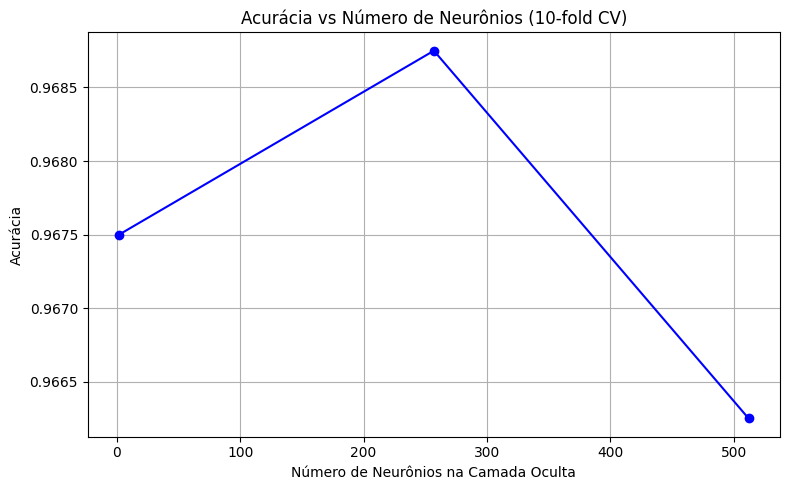

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Dados diretamente organizados
dados = {
    "2": 0.967500,
    "257": 0.968750,
    "512": 0.966250
}

# Cria DataFrame
df = pd.DataFrame(list(dados.items()), columns=["Neurônios", "Acurácia"])
df["Neurônios"] = df["Neurônios"].astype(int)

# Plota
plt.figure(figsize=(8, 5))
plt.plot(df["Neurônios"], df["Acurácia"], marker='o', linestyle='-', color='blue')
plt.title("Acurácia vs Número de Neurônios (10-fold CV)")
plt.xlabel("Número de Neurônios na Camada Oculta")
plt.ylabel("Acurácia")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:

# Carrega a base
df = pd.read_csv("vgg19_avg_256.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Normaliza
X = StandardScaler().fit_transform(X)

# Hiperparâmetros fixos já escolhidos
activation = func_ativacao
solver = 'adam'
hidden_neurons = 257
max_iter = 500

# Valores de taxa de aprendizado para testar
taxas_aprendizado = [0.0001, 0.001, 0.01, 0.1]
avaliacoes = ["70/30 Split", "10-fold CV"]

resultados_lr = {}

for taxa in taxas_aprendizado:
    for metodo in avaliacoes:
        nome_linha = f"LR={taxa} - {metodo}"
        
        mlp = MLPClassifier(
            activation=activation,
            solver=solver,
            hidden_layer_sizes=(hidden_neurons,),
            learning_rate_init=taxa,
            max_iter=max_iter,
            random_state=42
        )
        
        if metodo == "70/30 Split":
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=42)
            acc = mlp.fit(X_train, y_train).score(X_test, y_test)
        else:
            acc = cross_val_score(mlp, X, y, cv=10, scoring='accuracy').mean()

        resultados_lr[nome_linha] = acc

# Cria DataFrame de resultados
df_resultados_lr = pd.DataFrame.from_dict(resultados_lr, orient='index', columns=["Acurácia"])
print("\n📊 Resultados da Etapa 4 – Taxa de Aprendizado:")
print(df_resultados_lr)

# Salva em CSV
df_resultados_lr.to_csv("resultados_taxa_aprendizado_mlp.csv")



📊 Resultados da Etapa 4 – Taxa de Aprendizado:
                         Acurácia
LR=0.0001 - 70/30 Split  0.987500
LR=0.0001 - 10-fold CV   0.971250
LR=0.001 - 70/30 Split   0.991667
LR=0.001 - 10-fold CV    0.968750
LR=0.01 - 70/30 Split    0.991667
LR=0.01 - 10-fold CV     0.968750
LR=0.1 - 70/30 Split     0.979167
LR=0.1 - 10-fold CV      0.970000


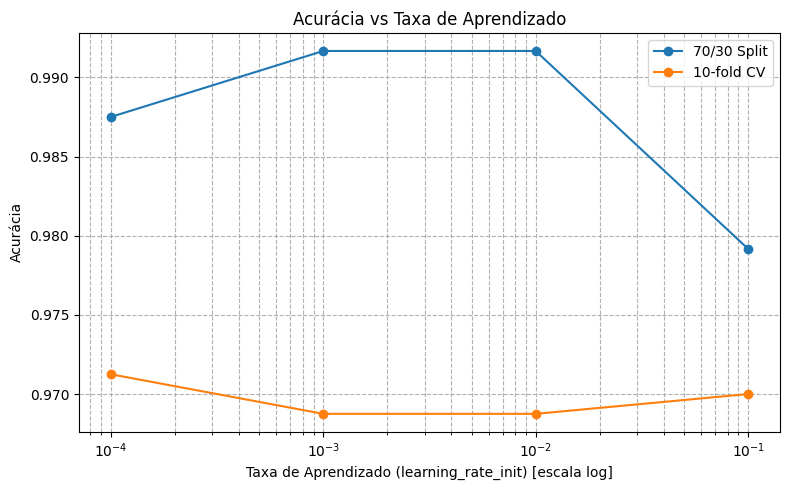

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dados que você passou
dados = {
    "LR=0.0001 - 70/30 Split": 0.987500,
    "LR=0.0001 - 10-fold CV": 0.971250,
    "LR=0.001 - 70/30 Split": 0.991667,
    "LR=0.001 - 10-fold CV": 0.968750,
    "LR=0.01 - 70/30 Split": 0.991667,
    "LR=0.01 - 10-fold CV": 0.968750,
    "LR=0.1 - 70/30 Split": 0.979167,
    "LR=0.1 - 10-fold CV": 0.970000,
}

# Monta DataFrame para facilitar manipulação
df = pd.DataFrame(list(dados.items()), columns=["Config", "Acurácia"])

# Extrai taxa de aprendizado e método de avaliação
df["LR"] = df["Config"].str.extract(r"LR=(\d*\.?\d+)").astype(float)
df["Método"] = df["Config"].str.extract(r"- (.*)")

# Ordena pelo learning rate
df = df.sort_values("LR")

# Plota
plt.figure(figsize=(8, 5))
for metodo in df["Método"].unique():
    df_m = df[df["Método"] == metodo]
    plt.plot(df_m["LR"], df_m["Acurácia"], marker='o', label=metodo)

plt.xscale("log")
plt.title("Acurácia vs Taxa de Aprendizado")
plt.xlabel("Taxa de Aprendizado (learning_rate_init) [escala log]")
plt.ylabel("Acurácia")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Parâmetros fixos escolhidos antes
activation = func_ativacao
solver = 'adam'
hidden_neurons = 257
learning_rate = 0.001  # Melhor taxa escolhida na etapa 4

max_iters = [500, 1000, 1500]
avaliacoes = ["70/30 Split", "10-fold CV"]

resultados_iter = {}

for it in max_iters:
    for metodo in avaliacoes:
        nome_linha = f"Iter={it} - {metodo}"
        
        mlp = MLPClassifier(
            activation=activation,
            solver=solver,
            hidden_layer_sizes=(hidden_neurons,),
            learning_rate_init=learning_rate,
            max_iter=it,
            random_state=42
        )
        
        if metodo == "70/30 Split":
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=42)
            acc = mlp.fit(X_train, y_train).score(X_test, y_test)
        else:
            acc = cross_val_score(mlp, X, y, cv=10, scoring='accuracy').mean()
        
        resultados_iter[nome_linha] = acc

# Exibe resultados
df_resultados_iter = pd.DataFrame.from_dict(resultados_iter, orient='index', columns=["Acurácia"])
print("\n📊 Resultados da Etapa 5 – Número de Iterações:")
print(df_resultados_iter)

# Salva resultados
df_resultados_iter.to_csv("resultados_num_iteracoes_mlp.csv")



📊 Resultados da Etapa 5 – Número de Iterações:
                         Acurácia
Iter=500 - 70/30 Split   0.991667
Iter=500 - 10-fold CV    0.968750
Iter=1000 - 70/30 Split  0.991667
Iter=1000 - 10-fold CV   0.968750
Iter=1500 - 70/30 Split  0.991667
Iter=1500 - 10-fold CV   0.968750


In [21]:
# Parâmetros escolhidos (ajuste se seu resultado for diferente)
activation = func_ativacao
solver = 'adam'
hidden_neurons = 257
learning_rate = 0.001
max_iter = 500

resultados_final = {}

# Modelo com os parâmetros finais
mlp = MLPClassifier(
    activation=activation,
    solver=solver,
    hidden_layer_sizes=(hidden_neurons,),
    learning_rate_init=learning_rate,
    max_iter=max_iter,
    random_state=42
)

# 70/30 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
acc_70_30 = mlp.fit(X_train, y_train).score(X_test, y_test)
resultados_final["Configuração Final - 70/30 Split"] = acc_70_30

# 10-fold Cross Validation
acc_cv = cross_val_score(mlp, X, y, cv=10, scoring='accuracy').mean()
resultados_final["Configuração Final - 10-fold CV"] = acc_cv

# Monta e mostra a tabela final
df_final = pd.DataFrame.from_dict(resultados_final, orient='index', columns=["Acurácia"])
print("\n📊 Resultados Finais - Configuração Escolhida:")
print(df_final)

# Salva tabela
df_final.to_csv("resultados_finais_mlp.csv")



📊 Resultados Finais - Configuração Escolhida:
                                  Acurácia
Configuração Final - 70/30 Split  0.991667
Configuração Final - 10-fold CV   0.968750


In [22]:


# Lista das 12 bases (ajuste o caminho se precisar)
bases = [
    "vgg19_avg_256.csv",
    "vgg16_max_256.csv",
    "vgg16_max_128.csv",
    "vgg16_avg_128.csv",
    "vgg19_max_256.csv",
    "vgg16_avg_256.csv",
    "vgg19_avg_256_pca10.csv",
    "vgg16_max_256_pca10.csv",
    "vgg16_max_128_pca10.csv",
    "vgg16_avg_128_pca10.csv",
    "vgg19_max_256_pca10.csv",
    "vgg16_avg_256_pca10.csv"
]

# Configurações fixas que você definiu
configs = [
    {"neurons": 64,  "lr": 0.001, "max_iter": 500},
    {"neurons": 128, "lr": 0.001, "max_iter": 500},
    {"neurons": 257, "lr": 0.001, "max_iter": 500},
    {"neurons": 257, "lr": 0.01,  "max_iter": 500},
    {"neurons": 257, "lr": 0.001, "max_iter": 1000},
    {"neurons": 257, "lr": 0.001, "max_iter": 1500},
    {"neurons": 512, "lr": 0.001, "max_iter": 500},
    {"neurons": 64,  "lr": 0.01,  "max_iter": 500},
    {"neurons": 128, "lr": 0.01,  "max_iter": 1000},
    {"neurons": 257, "lr": 0.01,  "max_iter": 1000},
]

activation = func_ativacao
solver = 'adam'
random_state = 42

# Dicionários para guardar os resultados
# Linhas: base + método; colunas: Config 1..10
resultados_acc = {}
index_names = []

for base in bases:
    # Carrega e prepara os dados
    df = pd.read_csv(base)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X = StandardScaler().fit_transform(X)

    for metodo in ["70/30 Split", "10-fold CV"]:
        linha = f"{base} - {metodo}"
        index_names.append(linha)
        resultados_acc[linha] = []

        for cfg in configs:
            mlp = MLPClassifier(
                activation=activation,
                solver=solver,
                hidden_layer_sizes=(cfg["neurons"],),
                learning_rate_init=cfg["lr"],
                max_iter=cfg["max_iter"],
                random_state=random_state
            )

            if metodo == "70/30 Split":
                # Uma execução única
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, stratify=y, random_state=random_state)
                mlp.fit(X_train, y_train)
                acc = mlp.score(X_test, y_test)

            else:
                # 10-fold CV média
                scores = cross_val_score(mlp, X, y, cv=10, scoring='accuracy')
                acc = scores.mean()

            resultados_acc[linha].append(acc)

# Monta DataFrame
df_resultados = pd.DataFrame.from_dict(resultados_acc, orient='index',
                                      columns=[f"Config {i+1}" for i in range(len(configs))])
df_resultados.index.name = "Base - Método"

print("\nTabela final de acurácia por base e configuração:")
print(df_resultados)

# Calcula média e desvio padrão por configuração (entre as 24 linhas)
media = df_resultados.mean(axis=0)
desvio = df_resultados.std(axis=0)

df_resumo = pd.DataFrame({"Média": media, "Desvio Padrão": desvio})

print("\nResumo geral (média e desvio padrão por configuração):")
print(df_resumo)

# Salva as tabelas
df_resultados.to_csv("tabela_acuracias_bases_configuracoes.csv")
df_resumo.to_csv("resumo_medio_desvio_configuracoes.csv")


c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti


Tabela final de acurácia por base e configuração:
                                       Config 1  Config 2  Config 3  Config 4  \
Base - Método                                                                   
vgg19_avg_256.csv - 70/30 Split        0.991667  0.991667  0.991667  0.991667   
vgg19_avg_256.csv - 10-fold CV         0.970000  0.970000  0.968750  0.968750   
vgg16_max_256.csv - 70/30 Split        0.966667  0.970833  0.970833  0.975000   
vgg16_max_256.csv - 10-fold CV         0.958750  0.961250  0.958750  0.961250   
vgg16_max_128.csv - 70/30 Split        0.958333  0.962500  0.966667  0.970833   
vgg16_max_128.csv - 10-fold CV         0.956250  0.958750  0.962500  0.960000   
vgg16_avg_128.csv - 70/30 Split        0.958333  0.962500  0.966667  0.970833   
vgg16_avg_128.csv - 10-fold CV         0.958750  0.958750  0.957500  0.953750   
vgg19_max_256.csv - 70/30 Split        0.966667  0.966667  0.966667  0.970833   
vgg19_max_256.csv - 10-fold CV         0.965000  0.963750 